In [30]:
import netCDF4 as nc
import matplotlib.pyplot as plt

# Replace 'your_file.nc' with the path to your NetCDF file
file_path = 'joined.nc'


# Open the NetCDF file
dataset = nc.Dataset(file_path)

print(dataset.variables.keys())

dict_keys(['time', 'lon', 'lon_bnds', 'lat', 'lat_bnds', 'tas'])


In [31]:
temperature_var = dataset.variables['tas']

print(temperature_var.dimensions,
      temperature_var.shape,
      temperature_var.units,
      temperature_var.long_name)

('time', 'lat', 'lon') (2208, 640, 1280) K Near-Surface Air Temperature


In [32]:
# get the 24 time steps at the 13th latitude and 13th longitude
x = 12
y = 12
temperature_at_xy = temperature_var[:, x, y]
print(temperature_at_xy.shape)

(2208,)


In [33]:
# get the time values
time_var = dataset.variables['time']
# print the time values
print(time_var[:])

[0.000e+00 1.000e+00 2.000e+00 ... 2.205e+03 2.206e+03 2.207e+03]


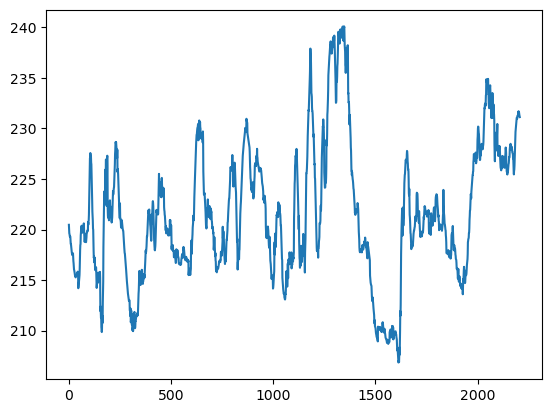

In [34]:
# plot the data
plt.plot(time_var[:], temperature_at_xy)
plt.show()

In [35]:
import numpy as np

# calulate the nearest latitude and longitude values to given coordinates
lat_var = dataset.variables['lat']
lon_var = dataset.variables['lon']

# given latitude and longitude values
given_lat = 53.55
given_lon = 9.95

# binary search to find the nearest latitude and longitude values
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="right")
    if idx > 0 and (idx == len(array) or np.abs(value - array[idx-1]) < np.abs(value - array[idx])):
        return idx-1
    else:
        return idx
    
lat_nearest_idx = find_nearest(lat_var[:], given_lat)
lon_nearest_idx = find_nearest(lon_var[:], given_lon)

print(lat_nearest_idx, lon_nearest_idx)
print(lat_var[lat_nearest_idx], lon_var[lon_nearest_idx])



510 35
53.536276141501205 9.84375


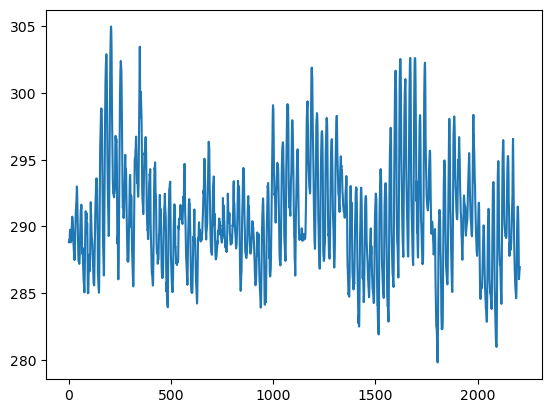

In [36]:
# plot at the nearest latitude and longitude values
temperature_at_nearest_lat_lon = temperature_var[:, lat_nearest_idx, lon_nearest_idx]
plt.plot(time_var[:], temperature_at_nearest_lat_lon)

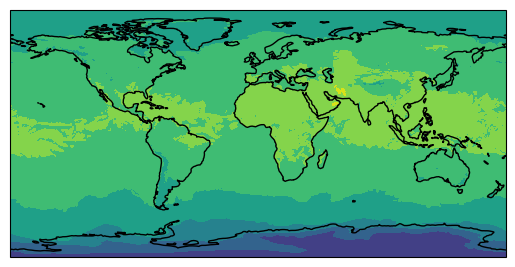

In [37]:
# plot the world on a map at a given time stamp. Use colors for the temperature values
import cartopy.crs as ccrs

# get the time stamp
time_idx = 12
temperature_at_time_idx = temperature_var[time_idx, :, :]
# plot the temperature values on a map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(lon_var[:], lat_var[:], temperature_at_time_idx)
plt.show()

In [38]:
# Preparing Trainings Data

given_lat = 53.55
given_lon = 9.95

lat_idx = find_nearest(lat_var[:], given_lat)
lon_idx = find_nearest(lon_var[:], given_lon)

# 9x9 grid around the given latitude and longitude values
lat_idx_min = lat_idx - 4
lat_idx_max = lat_idx + 4
lon_idx_min = lon_idx - 4
lon_idx_max = lon_idx + 4

# append p % of the timesteps
p = 0.1
# maximum number is 10
mask_n = min(10, int(len(time_var[:]) * p))
# get n random different idx values in the range of the time_var
mask_idx = np.random.choice(len(time_var[:]), mask_n, replace=False) + 1
# add 1 to each of the idx values
mask_idx = sorted(mask_idx)
print(mask_idx)

[48, 313, 340, 863, 1093, 1505, 1887, 2087, 2094, 2101]


In [39]:
# run the cdo shell command to delete,timestep= mask_idx and to cut out the 9x9 grid around the given latitude and longitude values
import subprocess


# cut out the 9x9 grid
cdo_command = f'cdo selindexbox,{lat_idx_min},{lat_idx_max},{lon_idx_min},{lon_idx_max} {file_path} temp.nc'
subprocess.call(cdo_command, shell=True)
# create training timesteps and evalutation timesteps
cdo_command = f'cdo delete,timestep={",".join(map(str, mask_idx))} temp.nc ../data/train/9x9_training.nc'
subprocess.call(cdo_command, shell=True)
cdo_command = f'cdo seltimestep,{",".join(map(str, mask_idx))} temp.nc ../data/val/9x9_training.nc'
subprocess.call(cdo_command, shell=True)

# generate some expected output data
command = f'cp ../data/train/9x9_training.nc ../data/train/9x9_training_expected.nc'
subprocess.call(command, shell=True)
# load the expected output data and manipulate it
with nc.Dataset('../data/train/9x9_training_expected.nc', 'r+') as dataset:
    # for each timestep
    for i in range(len(dataset.variables['time'][:])):
        # set all lat and long values to the median value of the 9x9 grid
        dataset.variables['tas'][i, :, :] = dataset.variables['tas'][i, 0, 0]

command = f'cp ../data/val/9x9_training.nc ../data/val/9x9_training_expected.nc'
subprocess.call(command, shell=True)

# load the expected output data and manipulate it
with nc.Dataset('../data/val/9x9_training_expected.nc', 'r+') as dataset:
    # for each timestep
    for i in range(len(dataset.variables['time'][:])):
        # set all lat and long values to the value of the 0 lat and 0 long value
        dataset.variables['tas'][i, :, :] = dataset.variables['tas'][i, 0, 0]

# delete the temporary file
command = f'rm temp.nc'
subprocess.call(command, shell=True)

0

In [40]:
from climatereconstructionai import train

train("train_args.txt")

KeyboardInterrupt: 